In [1]:
# ==============================================================================
# 1. PERSIAPAN LINGKUNGAN DAN PEMUATAN DATA
# ==============================================================================

# Instal TensorFlow dan Keras jika belum ada (biasanya sudah ada di Colab)
# !pip install tensorflow pandas numpy scikit-learn matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Nama file yang telah Anda unggah
file_name = 'hargaa baru(2).csv'

# Baca data
df = pd.read_csv(file_name)

print("Lima baris pertama data:")
print(df.head())
print("\nInformasi Data:")
print(df.info())

Lima baris pertama data:
           tanggal    harga
0  07 October 2020  19944.0
1  08 October 2020  19991.0
2  09 October 2020  20871.0
3  10 October 2020  20039.0
4  11 October 2020  20288.0

Informasi Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   tanggal  1827 non-null   object 
 1   harga    1608 non-null   float64
dtypes: float64(1), object(1)
memory usage: 28.7+ KB
None


In [2]:
# ==============================================================================
# 2. PRA-PEMROSESAN DATA
# ==============================================================================

# Konversi kolom 'tanggal' menjadi tipe data datetime
df['tanggal'] = pd.to_datetime(df['tanggal'])
df.set_index('tanggal', inplace=True)

# Pilih kolom harga
data = df[['harga']].copy()

# Penanganan Nilai Hilang (Missing Values)
# Untuk data time series, metode 'ffill' (forward fill) sering digunakan untuk
# mengisi nilai yang hilang dengan nilai sebelumnya yang valid.
print(f"\nJumlah nilai NaN sebelum diisi: {data['harga'].isnull().sum()}")
data['harga'].fillna(method='ffill', inplace=True)
print(f"Jumlah nilai NaN setelah diisi: {data['harga'].isnull().sum()}")

# Normalisasi/Skala Data
# Scaling sangat penting untuk LSTM/Neural Networks
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)


Jumlah nilai NaN sebelum diisi: 219
Jumlah nilai NaN setelah diisi: 0


/tmp/ipython-input-1854100627.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['harga'].fillna(method='ffill', inplace=True)
/tmp/ipython-input-1854100627.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['harga'].fillna(method='ffill', inplace=True)


In [3]:
# ==============================================================================
# 3. PEMBENTUKAN DATASET UNTUK LSTM
# ==============================================================================

# Fungsi untuk membuat dataset urutan (sequences)
def create_dataset(dataset, look_back=1):
    """
    Mengubah array menjadi dataset yang dapat digunakan untuk supervised learning.
    look_back: Jumlah hari/time step yang digunakan untuk memprediksi hari berikutnya.
    """
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        # Ambil urutan masa lalu (X)
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        # Ambil nilai masa depan (Y)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Definisikan panjang look_back (time steps). Umumnya 30, 60, atau 90 hari.
look_back = 60

# Buat dataset
X, y = create_dataset(scaled_data, look_back)

# Bagi data menjadi Training dan Test (misalnya 80% Training, 20% Test)
train_size = int(len(X) * 0.80)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

# Reshape input ke format [samples, time steps, features] yang dibutuhkan LSTM
# Di sini: [jumlah_data, look_back, 1 (karena hanya 1 fitur/kolom harga)]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(f"\nBentuk X_train setelah reshape: {X_train.shape}")
print(f"Bentuk X_test setelah reshape: {X_test.shape}")


Bentuk X_train setelah reshape: (1413, 60, 1)
Bentuk X_test setelah reshape: (354, 60, 1)


In [4]:
# ==============================================================================
# 4. MEMBANGUN DAN MELATIH MODEL LSTM
# ==============================================================================

# Bangun Model LSTM
model = Sequential()
# Tambahkan layer LSTM dengan 50 neuron, return_sequences=True untuk layer selanjutnya
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
# Tambahkan layer LSTM kedua dengan 50 neuron
model.add(LSTM(50, return_sequences=False))
# Tambahkan layer Dense (output layer)
model.add(Dense(1))

# Kompilasi Model
# Gunakan optimizer Adam dan Mean Squared Error (MSE) sebagai fungsi loss
model.compile(optimizer='adam', loss='mean_squared_error')

print("\nRingkasan Model:")
model.summary()

# Latih Model
# epoch: Jumlah iterasi pelatihan
# batch_size: Jumlah sampel yang diproses sebelum model diperbarui
history = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=2,
                    validation_data=(X_test, y_test))

print("\nModel telah selesai dilatih.")


Ringkasan Model:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
45/45 - 7s - 148ms/step - loss: 0.0407 - val_loss: 0.0043
Epoch 2/20
45/45 - 2s - 53ms/step - loss: 0.0049 - val_loss: 0.0029
Epoch 3/20
45/45 - 2s - 52ms/step - loss: 0.0041 - val_loss: 0.0026
Epoch 4/20
45/45 - 3s - 64ms/step - loss: 0.0038 - val_loss: 0.0023
Epoch 5/20
45/45 - 4s - 87ms/step - loss: 0.0036 - val_loss: 0.0021
Epoch 6/20
45/45 - 2s - 51ms/step - loss: 0.0031 - val_loss: 0.0016
Epoch 7/20
45/45 - 2s - 52ms/step - loss: 0.0027 - val_loss: 0.0014
Epoch 8/20
45/45 - 3s - 56ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 9/20
45/45 - 3s - 67ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 10/20
45/45 - 3s - 56ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 11/20
45/45 - 2s - 50ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 12/20
45/45 - 2s - 51ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 13/20
45/45 - 2s - 54ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 14/20
45/45 - 3s - 77ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 15/20
45/45 - 2s - 51ms/step - loss:

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Root Mean Squared Error (RMSE) Training: 567.27
Root Mean Squared Error (RMSE) Testing: 446.03


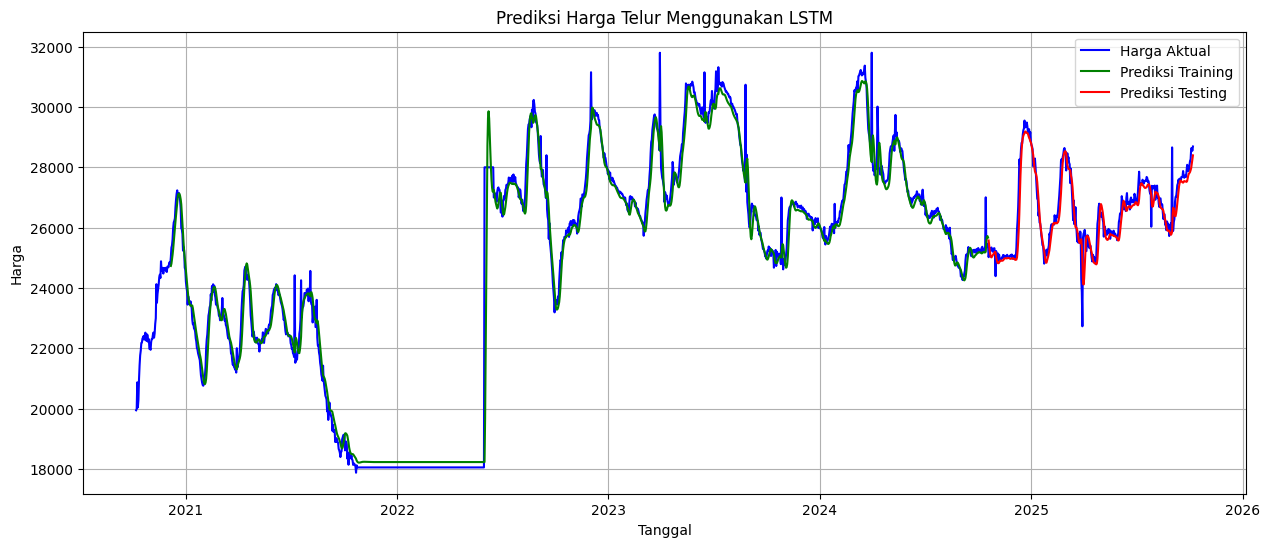

Plot hasil prediksi disimpan sebagai 'lstm_price_prediction.png'


<Figure size 640x480 with 0 Axes>

In [5]:
# ==============================================================================
# 5. EVALUASI DAN VISUALISASI HASIL
# ==============================================================================

# Prediksi pada data test
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Balikkan skala untuk mendapatkan nilai harga aktual
train_predict = scaler.inverse_transform(train_predict)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Hitung RMSE (Root Mean Squared Error) untuk evaluasi
from sklearn.metrics import mean_squared_error
train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict))

print(f"\nRoot Mean Squared Error (RMSE) Training: {train_rmse:.2f}")
print(f"Root Mean Squared Error (RMSE) Testing: {test_rmse:.2f}")

# Persiapan untuk Visualisasi
# Geser prediksi pelatihan untuk plot yang benar
train_plot = np.empty_like(scaled_data)
train_plot[:, :] = np.nan
train_plot[look_back:len(train_predict) + look_back, :] = train_predict

# Geser prediksi pengujian untuk plot yang benar
test_plot = np.empty_like(scaled_data)
test_plot[:, :] = np.nan
# CORRECTED: The start index for test_plot was incorrect.
# It should start after the train_predict values, accounting for the look_back period.
test_start_idx = look_back + len(train_predict)
test_end_idx = look_back + len(train_predict) + len(test_predict)
test_plot[test_start_idx : test_end_idx, :] = test_predict

# ==================================
# Visualisasi Hasil
# ==================================
plt.figure(figsize=(15, 6))

# Plot Harga Aktual
plt.plot(data.index, scaler.inverse_transform(scaled_data), label='Harga Aktual', color='blue')

# Plot Prediksi Training
# Indeks untuk data training dimulai dari look_back
train_indices = data.index[look_back : len(train_predict) + look_back]
plt.plot(train_indices, train_predict, label='Prediksi Training', color='green')

# Plot Prediksi Testing
# Indeks untuk data testing
# CORRECTED: Align test_indices with the corrected test_plot indexing.
test_indices = data.index[test_start_idx : test_end_idx]
plt.plot(test_indices, test_predict, label='Prediksi Testing', color='red')

plt.title('Prediksi Harga Telur Menggunakan LSTM')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.legend()
plt.grid(True)
plt.show()

# Simpan plot
plt.savefig('lstm_price_prediction.png')
print("Plot hasil prediksi disimpan sebagai 'lstm_price_prediction.png'")

Memulai perhitungan ARIMA (ini mungkin memakan waktu sebentar)...


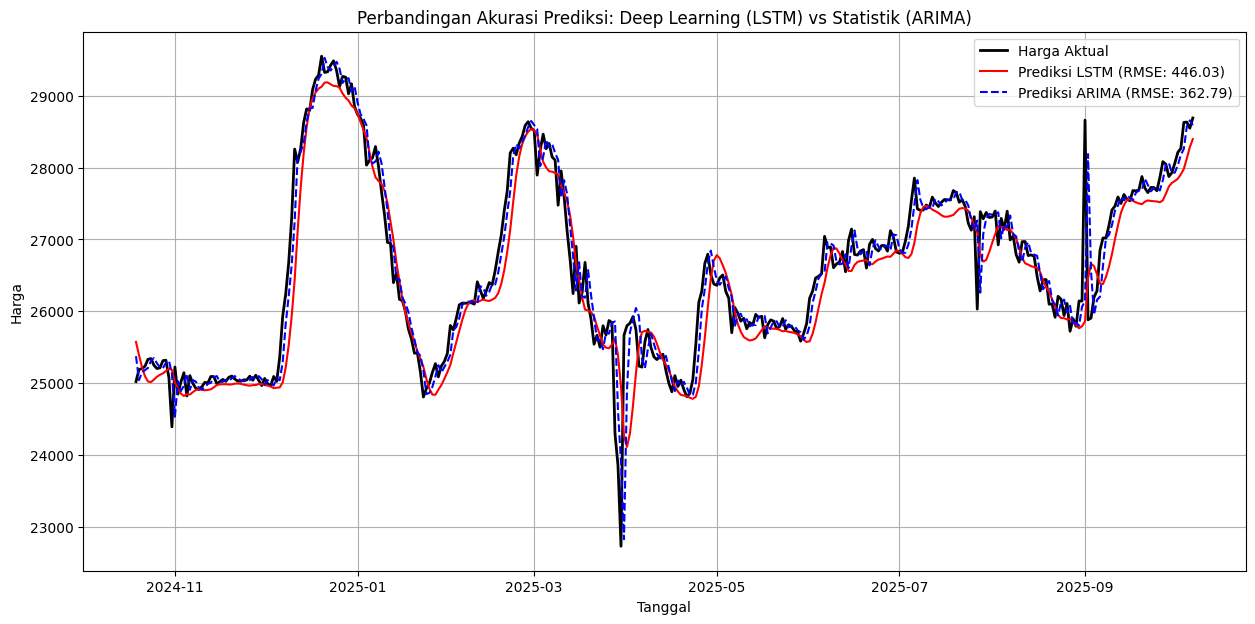


RMSE LSTM  : 446.03
RMSE ARIMA : 362.79


In [15]:
# ==============================================================================
# 6. PERBANDINGAN DENGAN METODE KONVENSIONAL (ARIMA)
# ==============================================================================
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore") # Mengabaikan peringatan konvergensi ARIMA

# Data asli sebelum scaling (ARIMA biasanya lebih baik dengan data asli)
history_arima = [x for x in y_train_actual.flatten()]
predictions_arima = []

# Loop Walk-forward validation (ARIMA memprediksi satu langkah ke depan)
print("Memulai perhitungan ARIMA (ini mungkin memakan waktu sebentar)...")
for t in range(len(y_test_actual)):
    # Inisialisasi model ARIMA (p,d,q)
    # Menggunakan order (5,1,0) sebagai awalan umum
    model_arima = ARIMA(history_arima, order=(5,1,0))
    model_arima_fit = model_arima.fit()

    # Prediksi
    output = model_arima_fit.forecast()
    yhat = output[0]
    predictions_arima.append(yhat)

    # Tambahkan observasi aktual ke dalam riwayat untuk prediksi berikutnya
    obs = y_test_actual[t]
    history_arima.append(obs[0])

# Hitung RMSE untuk ARIMA
arima_rmse = np.sqrt(mean_squared_error(y_test_actual, predictions_arima))

# ==================================
# Visualisasi Perbandingan
# ==================================
plt.figure(figsize=(15, 7))
test_dates = data.index[test_start_idx : test_end_idx]

# Plot Harga Aktual
plt.plot(test_dates, y_test_actual, label='Harga Aktual', color='black', linewidth=2)

# Plot Prediksi LSTM (dari kode sebelumnya)
plt.plot(test_dates, test_predict, label=f'Prediksi LSTM (RMSE: {test_rmse:.2f})', color='red')

# Plot Prediksi ARIMA
plt.plot(test_dates, predictions_arima, label=f'Prediksi ARIMA (RMSE: {arima_rmse:.2f})', color='blue', linestyle='--')

plt.title('Perbandingan Akurasi Prediksi: Deep Learning (LSTM) vs Statistik (ARIMA)')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.legend()
plt.grid(True)
plt.show()

print(f"\nRMSE LSTM  : {test_rmse:.2f}")
print(f"RMSE ARIMA : {arima_rmse:.2f}")